In [1]:
from PymoNNto import *

# neural network using LIF neurons

مدل استفاده شده برای شبیه سازی شبکه از دو مجموعه ی نورون تحریکی و مهاری به نسبت 8 به 2 بهره می‌برد. در این مدل همین دو جمعیت نورونی تعریف شده و بین نورون های دو بخش دورن خودشان و بین دو جمعیت ارتباط وجود دارد. جریانی که به عنوان ورودی اعمال می‌شود برای تمام آنها یکسان است. وزن ارتباط های سیناپسی به حالت یکنواخت در کل شبکه تعین شده. برای تغیر الگوی ارتباطی پارامتر تراکم در نظر گرفته شده تغیر می‌کند که در حالت پایه با یک شبکه ی کاملا متصل با تمام اتصالات نورونی تراکم 1 می باشد. تعداد نورون ها را در کل ازمایش ها برابر 1000 تا نگه داشتم. در هر شبکه ی ساخته شده به ازای پارامترهای تعریف شده نمودارهای زیر رسم می‌شوند.
ولتاژ-زمان به ازای تک تک نورون ها
ولتاژ(میانگین)-زمان به ازای دو جمعیت تحریکی و مهاری
رستر پلات فعالیت نورون های شبکه
فعالیت شبکه-زمان
جریان-زمان

In [2]:
def plot_mean_vt(ni, ne):
    plt.plot([np.mean(i) for i in ni['n.v',0]],color='orange')
    plt.plot([np.mean(i) for i in ne['n.v',0]],color='blue')
    plt.xlabel('iterations')
    plt.ylabel('voltage')
    plt.show()

In [3]:
def plot_It(ni, ne):
    #plt.plot(ne['n.I',0],'blue')
    #plt.plot(ni['n.I',0],'orange')
    ni_i = [np.mean(i) for i in ni['n.I',0]]
    ne_i = [np.mean(i) for i in ne['n.I',0]]
    t = len(ne_i)
    plt.plot([(0.2*ni_i[i])+(0.8*ne_i[i]) for i in range(t)],'black')
    plt.xlabel('iterations')
    plt.ylabel('current')
    plt.show()

In [4]:
def plot_activity(ni, ne):
    activity = []
    for t in range(1000):
        fired_t = 0
        for n in ne['n.fired', 0][t]:
            if n:
                fired_t += 1
        for n in ni['n.fired', 0][t]:
            if n:
                fired_t += 1
        activity.append(fired_t)
    plt.plot(activity,'black')
    plt.xlabel('iterations')
    plt.ylabel('activity')
    plt.show()

In [5]:
def plot_raster(ni, ne, ne_size):
    ne_fired = []
    for t in ne['n.fired', 0]:
        ne_fired_t = []
        for n in range(len(t)):
            if t[n]:
                ne_fired_t.append(n)
        ne_fired.append(ne_fired_t)
    ni_fired = []
    for t in ni['n.fired', 0]:
        ni_fired_t = []
        for n in range(len(t)):
            if t[n]:
                ni_fired_t.append(n + ne_size)
        ni_fired.append(ni_fired_t)  
      
    t=[0 for i in range(1000)]
    for i in range(len(ne_fired)):
        plt.scatter([i for j in range(len(ne_fired[i]))],ne_fired[i],color='blue',s=1)
    for i in range(len(ni_fired)):
        plt.scatter([i for j in range(len(ni_fired[i]))],ni_fired[i],color='orange',s=1)
    plt.xlabel('iterations')
    plt.ylabel('neuron index')
    plt.show()

In [6]:
def plot_ut(ni, ne, the, thi):
    plt.plot(ni['n.v', 0])
    plt.plot(ne['n.v', 0])
    plt.axhline(thi,color='black',linestyle='dashed')
    plt.axhline(the,color='black',linestyle='dashed')
    plt.xlabel('iterations')
    plt.ylabel('voltage')
    plt.show()

In [7]:
def current(x,a=100,b=100):
    if x//b%2 == 0:
        return a
    return x//b*a*0.1

In [8]:
def network_setup(params):
    class LIF_main(Behaviour):

        def set_variables(self, n):
            self.set_init_attrs_as_variables(n)
            n.v = n.get_neuron_vec('uniform')*n.v_rest
            n.fired = n.get_neuron_vec() > 0
            n.dt = 0.1

        def new_iteration(self, n):

            n.v += ((n.v_rest-n.v)+n.R*n.I)*(n.dt/n.tau)

            n.fired = n.v > n.v_threshold
            if np.sum(n.fired) > 0:
                n.v[n.fired] = n.v_reset            

    class LIF_input(Behaviour):

        def set_variables(self, n):
            for synapse in n.afferent_synapses['All']:
                synapse.W = synapse.get_synapse_mat(params['density'][0],density=params['density'][1])

            n.I = n.get_neuron_vec()

        def new_iteration(self, n):
            #n.I = 100 * n.get_neuron_vec('uniform')
            n.I = current(n.iteration) * n.get_neuron_vec('uniform')
            #n.I += 0.02 * n.get_neuron_vec('uniform') 

            for s in n.afferent_synapses['GL']:
                n.I += np.sum(s.W[:, s.src.fired], axis=1)

            for s in n.afferent_synapses['GB']:
                n.I -= np.sum(s.W[:, s.src.fired], axis=1)  

    My_Network = Network()

    N_e = NeuronGroup(net=My_Network, tag='excitatory_neurons', size=params['N_e_size'], behaviour={
        1: LIF_main(R=params['N_e_R'], v_rest=params['N_e_rest'], v_reset=params['N_e_reset'],
                    v_threshold=params['N_e_threshold'], tau=params['N_e_tau']),
        2: LIF_input(),
        9: Recorder(tag='rec1', variables=['n.v', 'n.fired', 'n.I'])
    })

    N_i = NeuronGroup(net=My_Network, tag='inhibitory_neurons', size=params['N_i_size'], behaviour={
        1: LIF_main(R=params['N_i_R'], v_rest=params['N_i_rest'], v_reset=params['N_i_reset'],
                    v_threshold=params['N_i_threshold'], tau=params['N_i_tau']),
        2: LIF_input(),
        9: Recorder(tag='rec2', variables=['n.v', 'n.fired', 'n.I'])
    })

    SynapseGroup(net=My_Network, src=N_e, dst=N_e, tag='GL')
    SynapseGroup(net=My_Network, src=N_e, dst=N_i, tag='GL')
    SynapseGroup(net=My_Network, src=N_i, dst=N_e, tag='GB')
    SynapseGroup(net=My_Network, src=N_i, dst=N_i, tag='GB')

    return My_Network, N_e, N_i

In [9]:
def present_network_behaviour(param_set):
    
    Network, N_e, N_i = network_setup(param_set)
    Network.initialize()
    Network.simulate_iterations(param_set['Iterations'], measure_block_time=True)

    plot_ut(N_i, N_e,param_set['N_e_threshold'],param_set['N_i_threshold'])
    plot_mean_vt(N_i, N_e)
    plot_raster(N_i, N_e, param_set['N_e_size'])
    plot_activity(N_i, N_e)
    plot_It(N_i, N_e)

# 1st 

شاخص ترین مشاهده روی رسترپلات است. هرچه فعالیتهای جمعیت تحریکی در بازه ی کوتاه تری و به صورت شدیدتری انحام شده باشد به دنبال آن فعالیت نورون های مهاری روی بازه ی زمانی طولانی تری ادامه خواهد یافت. تا دوباره فعالیت نورون های تحریکی شدت بگیرد هیچ فعالیتی نداریم. البته با گذشت زمان این بازه های بدون فعالیت کوتاه می‌شود که مربوط است که تناوبی که در افت و خیز جریان ورودی وجود دارد. این افت جریان به مرور زمان کمتر می‌شود.زمان هایی که یک نورون فعال می‌شود تراکم روی نمودار اول ولتاژ-زمان به خوبی با بازه های رسترپلات تطبیق دارد.

init R
init v_rest
init v_reset
init v_threshold
init tau
init R
init v_rest
init v_reset
init v_threshold
init tau
1000xBatch: 1/1 (100%) 242.568ms


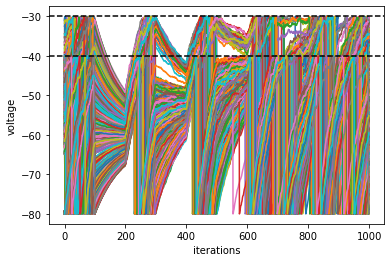

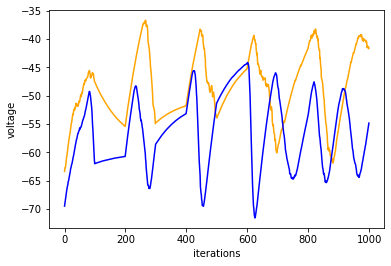

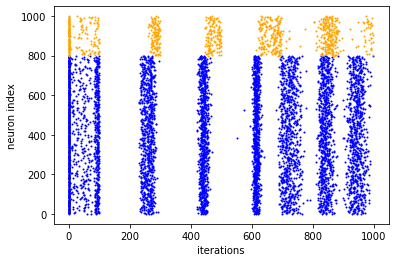

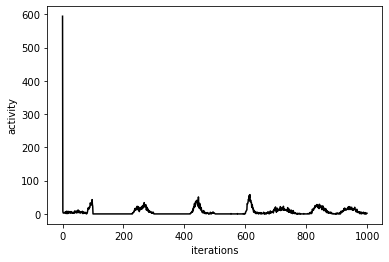

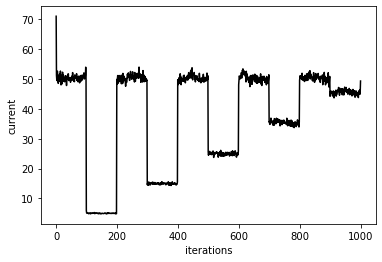

In [10]:
param_set1 ={
    'density' : ('random' , 0.1),
    'Iterations' : 1000,
    'N_e_size' : 800,
    'N_i_size' : 200,
    'N_e_threshold' : -40,
    'N_i_threshold' : -30,
    'N_e_R' : 1,
    'N_i_R' : 1,
    'N_e_rest' : -65,
    'N_i_rest' : -65,
    'N_e_reset' : -80,
    'N_i_reset' : -80,
    'N_e_tau' : 10,
    'N_i_tau' : 10
}

present_network_behaviour(param_set1)

# 2nd : full connection

همان نمودارهای بخش قبل در بازه های زمانی اتفاقات متراکم تری را رقم می‌زند ولی از لحاظ رفتار جمعیت ها همان وضعیت بخش قبلی است. در هر دو این ازمایش ها در زمان شروع همه ی نورون ها فعالیت دارند و با جریان ورودی فعال می‌شوند و بعد از آن ارتباطهای بین نورونی تاثیر می‌کنند و رفتار و کنش دو جمعیت در نمودارها قابل مشاهده می‌شود..

init R
init v_rest
init v_reset
init v_threshold
init tau
init R
init v_rest
init v_reset
init v_threshold
init tau
1000xBatch: 1/1 (100%) 220.254ms


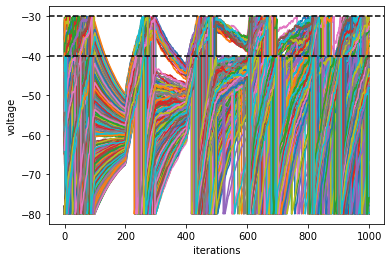

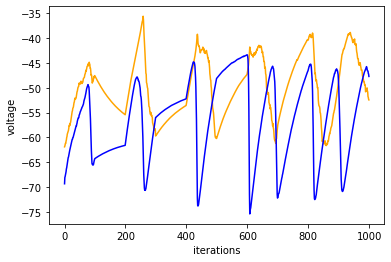

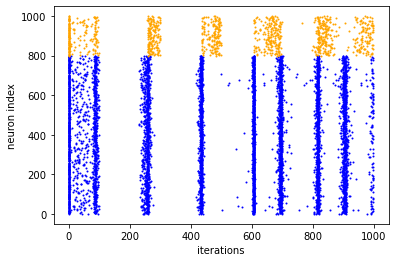

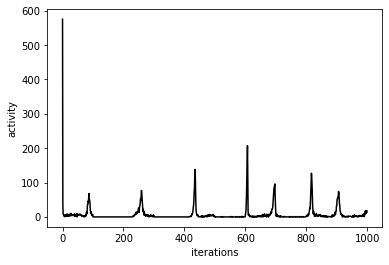

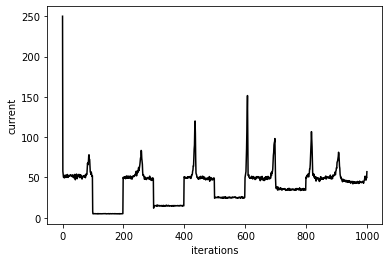

In [11]:
param_set2 ={
    'density' : ('uniform' , 1),
    'Iterations' : 1000,
    'N_e_size' : 800,
    'N_i_size' : 200,
    'N_e_threshold' : -40,
    'N_i_threshold' : -30,
    'N_e_R' : 1,
    'N_i_R' : 1,
    'N_e_rest' : -65,
    'N_i_rest' : -65,
    'N_e_reset' : -80,
    'N_i_reset' : -80,
    'N_e_tau' : 10,
    'N_i_tau' : 10
}

present_network_behaviour(param_set2)

# 3rd : switch N_e_threshold and N_i_threshold

تاثیر شاخص روی نمودارهای ولتاژ است. تا پیش از این نمودار ولتاژ میانگین نارنجی بالاتر قرار داشت ولی اینجا برعکس می‌شود. همچنین خطوط افقی روی نمودار ولتاژ همه نورون ها فعالیت دو گروه ها نشان می‌دهد با این تفاوت که جایشان عوض شده و منخنی های بالاتر، مربوز به نورون های تحرییکی هستند.تاثیر شاخص بعدی این است که ترتیب فعالیت گروه های تحریکی-مهاری و دینامیک این دو اگرچه به روال سابق روی بازه ی زمانی انجام می‌شود ولی ترتیب عملکردشان برعکس شده. اینجا بعد از بازه ی افت جریان ابتدا فعالیت نورون های مهاری را داریم و بعد از پایان فعالیت آن ها جمعیت تحریکی شروع به فعالیت می‌کند. این به دلیل این است که استانه ی نورون های مهاری پایین تر امده پس زوتر فعال می‌شوند.

init R
init v_rest
init v_reset
init v_threshold
init tau
init R
init v_rest
init v_reset
init v_threshold
init tau
1000xBatch: 1/1 (100%) 208.476ms


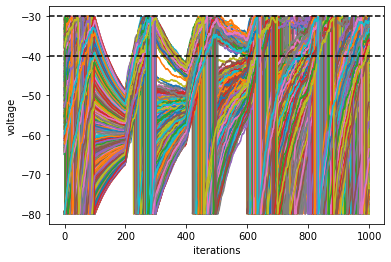

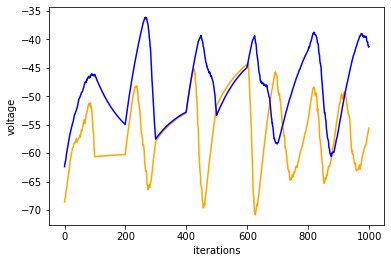

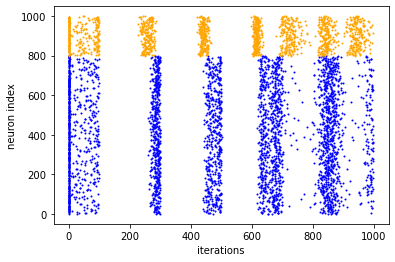

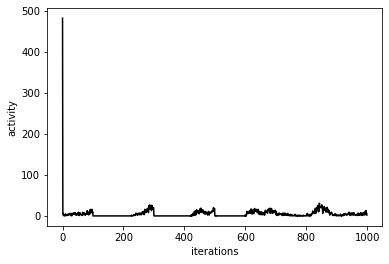

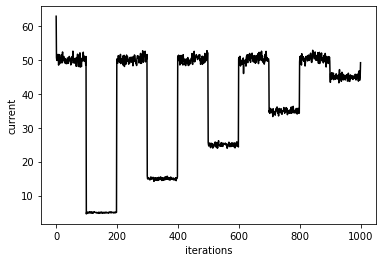

In [13]:
param_set3 ={
    'density' : ('random' , 0.1),
    'Iterations' : 1000,
    'N_e_size' : 800,
    'N_i_size' : 200,
    'N_e_threshold' : -30,
    'N_i_threshold' : -40,
    'N_e_R' : 1,
    'N_i_R' : 1,
    'N_e_rest' : -65,
    'N_i_rest' : -65,
    'N_e_reset' : -80,
    'N_i_reset' : -80,
    'N_e_tau' : 10,
    'N_i_tau' : 10
}

present_network_behaviour(param_set3)

# 4th : increase R for N_e population

روی رسترپلات واضح ترین نتیجه قابل مشاهده ست. فعالیت نورون های تحریکی در ابتدا به صورت متراکم در بازه های کوتاه زمانی انجام می‌گیرد و بعد با اعمال اثر مهاری ناشی از همان فعالیت شدید خود جمعیت که جمعیت مهاری را فعال کرده کنترل می‌شود. رفته رفته به دلیل اینکه مقاومت این نورون ها زیاد شده برای ایجاد اختلاف پتانسیل در اثر جریان های ورودی حساس تر شده اند و در نتیجه جریان های کم در زمان افت جریان هم باعث تحریک آن ها می‌شود. این فعالیت ها روی بازه های زمانی جریان کوتاه حالت یکنواحتی دارند

init R
init v_rest
init v_reset
init v_threshold
init tau
init R
init v_rest
init v_reset
init v_threshold
init tau
1000xBatch: 1/1 (100%) 308.414ms


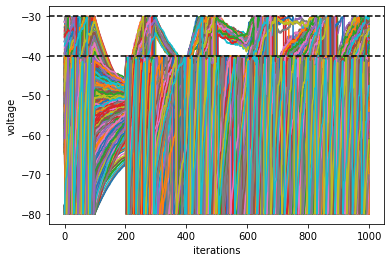

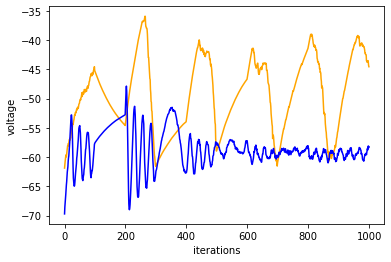

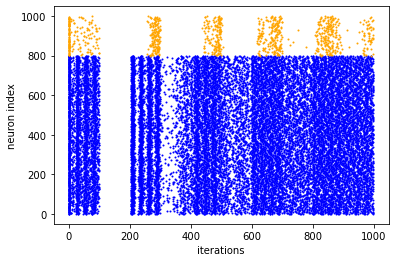

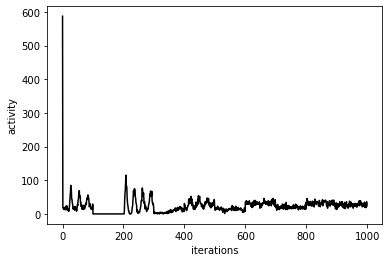

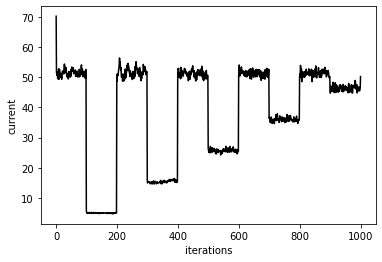

In [18]:
param_set4 ={
    'density' : ('random' , 0.1),
    'Iterations' : 1000,
    'N_e_size' : 800,
    'N_i_size' : 200,
    'N_e_threshold' : -40,
    'N_i_threshold' : -30,
    'N_e_R' : 3,
    'N_i_R' : 1,
    'N_e_rest' : -65,
    'N_i_rest' : -65,
    'N_e_reset' : -80,
    'N_i_reset' : -80,
    'N_e_tau' : 10,
    'N_i_tau' : 10
}
present_network_behaviour(param_set4)

# 5th : increase R for N_i

تاثیر اصلی افزایش مقاومت به طور کلی افزایش تغیرات ولتاژ به نسبت جریان ورودی ثابت است. نسبت به کل حالت های قبلی مقاومت نورون های این شبکه در بیشترین حالت است و این شدن ولتاژها را روی دو نمودار اول می‌شود دید. روی رسترپلات یکنواختی که در بخش قبل برای نورون های تحریکی پیش آمد اینجا برای نورون های مهاری هم به ورت شدیدتر داریم. هرچه جریان در زمان جلوتر می‌رود انگار که به یک جریان ثابت تبدیل می‌شود که در آن تعادل جمعیت های مهاری و تحریکی در این حالت یکنواختی که ایجاد شده حفظ می‌شود و تناوب فعالیت از بین میرود.

init R
init v_rest
init v_reset
init v_threshold
init tau
init R
init v_rest
init v_reset
init v_threshold
init tau
1000xBatch: 1/1 (100%) 388.380ms


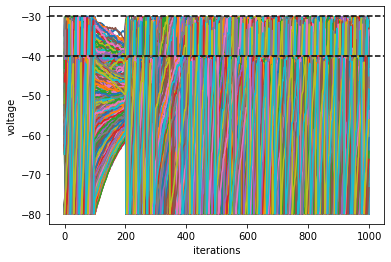

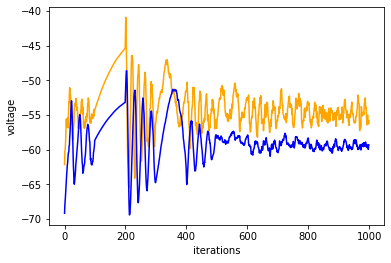

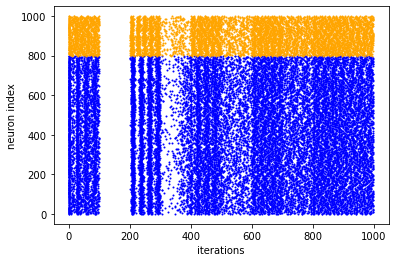

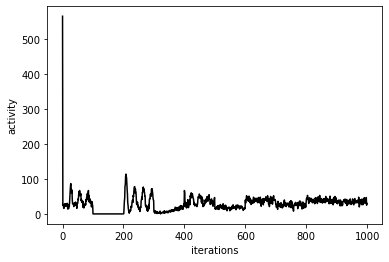

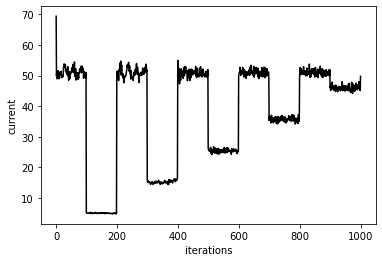

In [20]:
param_set5 ={
    'density' : ('random' , 0.1),
    'Iterations' : 1000,
    'N_e_size' : 800,
    'N_i_size' : 200,
    'N_e_threshold' : -40,
    'N_i_threshold' : -30,
    'N_e_R' : 3,
    'N_i_R' : 5,
    'N_e_rest' : -65,
    'N_i_rest' : -65,
    'N_e_reset' : -80,
    'N_i_reset' : -80,
    'N_e_tau' : 10,
    'N_i_tau' : 10
}
present_network_behaviour(param_set5)

# 6th : decrease tau for N_e

کاهش تاو همان تاثیر مشابه افزایش مقاومت را به صورت شدیدتری اعمال می‌کند. مخصوصا اگر روی نمودار ولتاژ نگاه کنیم از قبل هم می‌دانیم که تاثیر اصلی تاو همین است که شیب تغیرات اهتلاف پتانسیل را زیاد و کم می‌کند. جدا از این اثری که قابل انتطار بود یک مشاهده ی دیگر هم روی نمودار اکتیویتی- زمان داریم. به نسبت تمام حالت های قبلی شدت فعالیت در بازه های افزایش جریان نشان دهنده تعداد زیاد نورون هایی است که در این شبکه با این جریان فعال می‌شوند. طیق آنچه اول گفته شد این تعداد زیاد مربوز به فعالیت شدید نورونهای تحریکی است اما این فعالیت روی نقاط افت جریان باعث فعالیت شدید و کوتاه مدت نورون های مهاری هم می‌شود. برای همین است که در نیمه ی دوم نمودار فعالیت تقریبا  فعالیت صفر نداریم.

init R
init v_rest
init v_reset
init v_threshold
init tau
init R
init v_rest
init v_reset
init v_threshold
init tau
1000xBatch: 1/1 (100%) 593.534ms


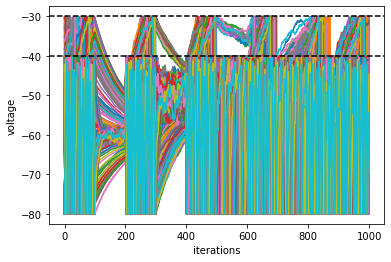

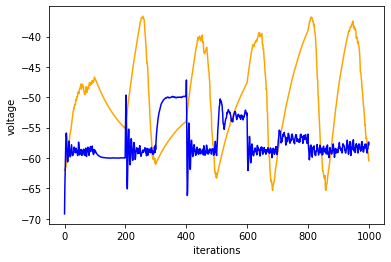

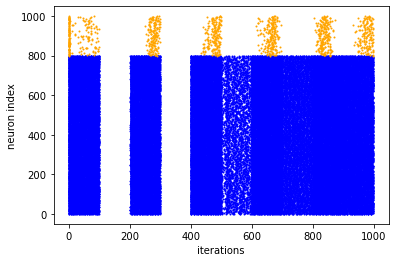

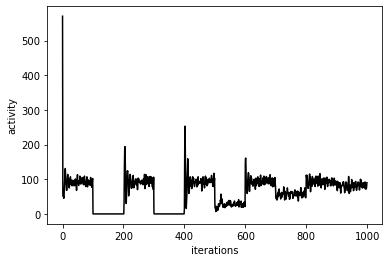

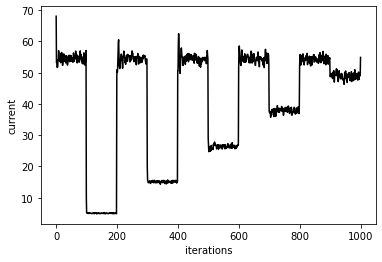

In [21]:
param_set6 ={
    'density' : ('random' , 0.1),
    'Iterations' : 1000,
    'N_e_size' : 800,
    'N_i_size' : 200,
    'N_e_threshold' : -40,
    'N_i_threshold' : -30,
    'N_e_R' : 1,
    'N_i_R' : 1,
    'N_e_rest' : -65,
    'N_i_rest' : -65,
    'N_e_reset' : -80,
    'N_i_reset' : -80,
    'N_e_tau' : 1,
    'N_i_tau' : 10
}
present_network_behaviour(param_set6)

# 7th : increase rest voltage for N_e

در ساده ترین بیان با ثابت ماندن استانه و افزایش ولتاژ استاحت میتوان با جریان کمتری نورون را به استانه و فعالیت رساند. اتفاقی رو روی نمودار دوم ولتاژ قابل مشاهده ست همین نوسان فعالیت جمعیت نورون تحریکی وسپس بازگشت به ولتاژ ریست و دوباره فعالیت است. این تناوب را روی نمودار رسترپلات هم میتوان دید. نسبت به آزمایش اول بازه های فعالیت نورون های تحریکی به هم نزدیک تر شده ولی در اوایل کار که جریان در زمان افت جریان هم کم است نمی تواند فعالیت نورون های مخاری را بیانگیزد. اما هرچه جریان به سمت ثابت شده می‌رود در زمان های بزرگتر رفتار دو جمعیت هم در ارتباط باهم به سمت یکنواخت تر شدن می رود. روی نمودار فعالیت-زمان در انتهای نمودار به جای افت و خیزها می‌توان منخنی های کوچک فعالیت را دید. اگر زمان را جلوتر هم ببریم این منهنی های کوتاه قد به فاصله های نزدیک از هم و با لرزش کمتر تکرار خواهند شد. 

init R
init v_rest
init v_reset
init v_threshold
init tau
init R
init v_rest
init v_reset
init v_threshold
init tau
1000xBatch: 1/1 (100%) 263.403ms


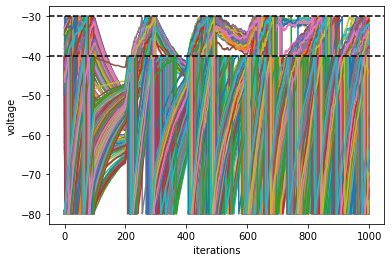

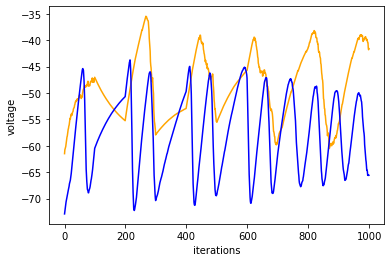

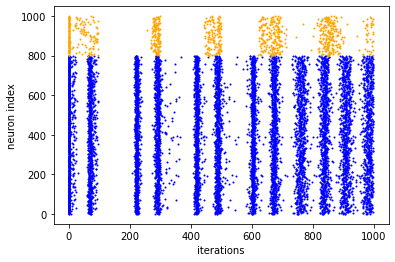

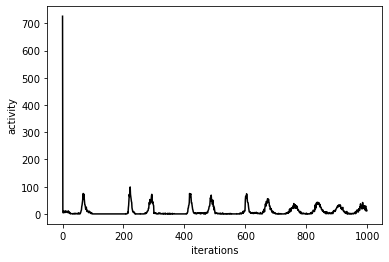

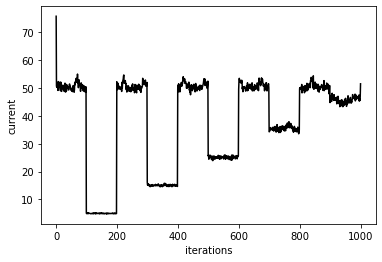

In [22]:
param_set7 ={
    'density' : ('random' , 0.1),
    'Iterations' : 1000,
    'N_e_size' : 800,
    'N_i_size' : 200,
    'N_e_threshold' : -40,
    'N_i_threshold' : -30,
    'N_e_R' : 1,
    'N_i_R' : 1,
    'N_e_rest' : -50,
    'N_i_rest' : -65,
    'N_e_reset' : -80,
    'N_i_reset' : -80,
    'N_e_tau' : 10,
    'N_i_tau' : 10
}
present_network_behaviour(param_set7)